----------------------------------------------------------------
## 해커톤문제
----------------------------------------------------------------

최근 온라인 거래를 이용하는 고객들이 많이 늘어나고 있어 고객들의 log 데이터가 많이 늘어나고 있습니다. 온라인 거래 고객 log 데이터를 이용하여 고객들의 미래 소비를 예측 분석프로젝트를 진행하려 합니다.
고객들의 월별 총 구매 금액을 확인했을 때 연말에 소비가 많이 이루어지고 있는 것으로 확인이 되었습니다. 그리하여 12월을 대상으로 고객들에게 프로모션을 통해 성공적인 마케팅을 하기 위해 모델을 만들려고 합니다.
온라인 거래 log 데이터는 2009년 12월부터 2011년 11월까지의 온라인 상점의 거래 데이터가 주어집니다. 2011년 11월 까지 데이터를 이용하여 2011년 12월의 고객 구매액 300초과 여부를 예측해야 합니다.


--------------------------------------------------------
<변수설명>

order_id : 주문 번호. 데이터에서 같은 주문번호는 동일 주문을 나타냄

product_id : 상품 번호

description : 상품 설명

quantity : 상품 주문 수량

order_date : 주문 일자

price : 상품 가격

customer_id : 고객 번호

country : 고객 거주 국가

total : 총 구매액(quantity X price)

--------------------------------------------------------

In [47]:
## 데이터 불러오기
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

df=pd.read_csv('/content/drive/MyDrive/hackathon/train.csv')

label = pd.read_csv('/content/drive/MyDrive/hackathon/label.csv')


In [48]:
## 데이터 변수 확인(결측치 없음)
df.info()
df.isna().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_id     780502 non-null  object 
 1   product_id   780502 non-null  object 
 2   description  780502 non-null  object 
 3   quantity     780502 non-null  int64  
 4   order_date   780502 non-null  object 
 5   price        780502 non-null  float64
 6   customer_id  780502 non-null  int64  
 7   country      780502 non-null  object 
 8   total        780502 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


,quantity,price,customer_id,total
count,780502.000000,780502.000000,780502.000000,780502.000000
mean,12.623307,6.140931,15313.393466,33.715373
std,143.906302,119.042266,1695.765797,274.207403
min,-74215.000000,0.000000,12346.000000,-127352.940000
25%,2.000000,2.062500,13963.000000,7.260000
50%,5.000000,3.217500,15239.000000,19.470000
75%,12.000000,6.187500,16788.000000,32.175000
max,74215.000000,64300.500000,18287.000000,127352.940000


In [49]:
## unique한 customer_id 갯수 => 5914
len(df.customer_id.unique())

5914

In [50]:
## datetime 년도,월,년도+월 분리변수 생성
df['year_month'] = pd.to_datetime(df['order_date'], format='%Y-%m', errors='raise')
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

#df['year_month'] = df['order_date'].apply(year_month)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  object        
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
 9   year_month   780502 non-null  datetime64[ns]
 10  year         780502 non-null  int64         
 11  month        780502 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 71.5+ MB


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,year,month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12-01 07:45:00,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12-01 07:45:00,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12-01 07:45:00,2009,12


In [51]:
## 피벗테이블(테이블 작업은 가능하나 값 알아보기가 안좋다...)
pb1 = pd.pivot_table(df,              # 피벗할 데이터프레임
                     index = 'month',    # 행 위치에 들어갈 열
                     columns = 'year',   # 열 위치에 들어갈 열
                     values = 'total',   # 데이터로 사용할 열
                     aggfunc = ['sum'])  # 데이터 집계함수
pb1

sum                            
year          2009          2010          2011
month                                         
1              NaN  8.752202e+05  7.816576e+05
2              NaN  8.045341e+05  7.186312e+05
3              NaN  1.045142e+06  9.546507e+05
4              NaN  9.207129e+05  7.016174e+05
5              NaN  9.204911e+05  1.067569e+06
6              NaN  9.384945e+05  1.001323e+06
7              NaN  9.254608e+05  9.456353e+05
8              NaN  9.656781e+05  1.014879e+06
9              NaN  1.284558e+06  1.533438e+06
10             NaN  1.586509e+06  1.605956e+06
11             NaN  1.862892e+06  1.859245e+06
12     1089206.415  9.114152e+05           NaN

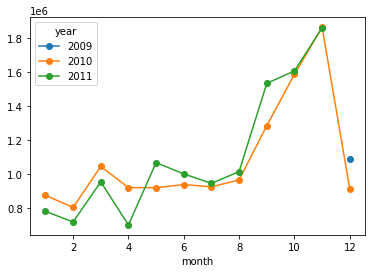

In [52]:
## 연도+월별 total 합계 그래프 ==> total 합계 10월,11월 급격히 증가, 12월에는 급격히 감소
sum_total = df.pivot_table(values='total', index='month', columns='year', aggfunc=sum)
ax=sum_total.plot(marker = 'o')
plt.show()

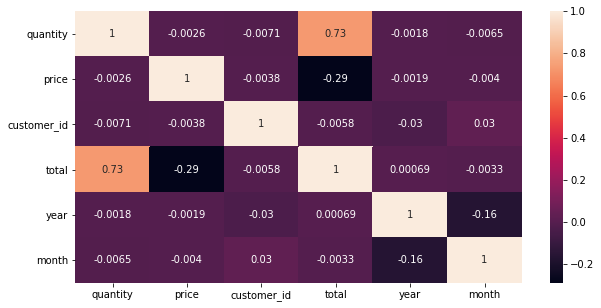

In [53]:
## 상관계수 그래프
corr = df.corr()
fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(corr, annot = True)
plt.show()


In [54]:
## country 라벨 인코딩(우선은 라벨 인코딩으로...) => 최종데이터에 반영은 안함 그냥 작업만...

from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
df['country_code'] = lbe.fit_transform(df['country'])
df.head()


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,year,month,country_code
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12-01 07:45:00,2009,12,38
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12,38
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12-01 07:45:00,2009,12,38
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12-01 07:45:00,2009,12,38
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12-01 07:45:00,2009,12,38


In [55]:
############################################################################################
## 연도+월별, 고객번호별 total 합계 데이터 기존데이터에 merge (사례수 : 5914*24=141936)
############################################################################################

# ############################################################################################
# ## 내가 하면 왜 26307 사례수가 나올까 => 구매한 금액이 없는 경우 해당 customer_id가 누락되어
# ############################################################################################

# ##object(year_month)는 merge하면 에러난다 숫자형으로 바꿔보자

# ## year_month 숫자형으로 변환
# df['year_month'] = pd.to_datetime(df.year_month).dt.strftime("%Y%m")
# def trans(x) :
#     x = x.replace('-','')
#     return int(x)
# df['year_month'] = df['year_month'].apply(trans)


# ## 연도+월별, 고객번호별 total 합계 데이터 기존데이터에 merge
# total_sum = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
# merge_temp = pd.merge(df, total_sum, on=['customer_id','year_month'], how='left')


# ## 변수명이 이상하게 바뀐다 ??? 다시 변경함 <=원래 이렇게 바뀐다고 함
# merge_temp.columns = merge_temp.columns.str.replace('_x','')
# merge_temp.columns = merge_temp.columns.str.replace('_y','_sum')
# merge_temp


# ## duplicates 활용(customer_id 월별 중복삭제) => 사례수가 이상하다...
# merge_temp = merge_temp.drop_duplicates(subset=['customer_id','year_month'], keep='last')
# merge_temp

# merge_temp['customer_id']==16717


###########################################################################################
## 강사님 eda로  group by 및 merge 데이터 생성 (사례수 : 5914*24=141936))
###########################################################################################
def make_time_series_data(Input, 기준):
    
    # 기준을 잡습니다. 기준은 여기서 %Y-%m 입니다.
    year_month = ['customer_id'] + [기준]
    data = Input.copy()    
    
    
    data[기준] = pd.to_datetime(df.order_date).dt.strftime(기준)    
    data.order_date = pd.to_datetime(df.order_date)
    
    # 월단위의 틀을 만들어주고, 기준으로 aggregation을 해준 다음에 merge를 해줄 것입니다
    times = pd.date_range('2009-12-01', periods= (data.order_date.max() - data.order_date.min()).days + 1, freq='1d')    
    customerid_frame = np.repeat(data.customer_id.unique(), len(times))
    date_frame = np.tile(times, len(data.customer_id.unique()))

    frame = pd.DataFrame({'customer_id':customerid_frame,'order_date':date_frame})
    frame[기준] = pd.to_datetime(frame.order_date).dt.strftime(기준)
    
    # group by
    data_group = data.groupby(year_month).sum().reset_index()
    frame_group = frame.groupby(year_month).count().reset_index().drop(['order_date'], axis=1)
    
    # merge
    merge = pd.merge(frame_group, data_group, on=year_month, how='left').fillna(0)
    merge = merge.rename(columns={기준 : 'year_month'})
    return merge


## customer_id를 월단위별로 구매액 합계 데이터 정리(구매기록이 없는 경우는 0 으로 처리됨) 
merge_temp = make_time_series_data(df, "%Y-%m")
merge_temp


,customer_id,year_month,quantity,price,total,year,month,country_code
0,12346,2009-12,26.0,31.3500,187.2750,10045.0,60.0,190.0
1,12346,2010-01,19.0,200.4750,-22.2750,10050.0,5.0,190.0
2,12346,2010-02,0.0,0.0000,0.0000,0.0,0.0,0.0
3,12346,2010-03,5.0,44.6325,44.6325,10050.0,15.0,190.0
4,12346,2010-04,0.0,0.0000,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
141931,18287,2011-07,0.0,0.0000,0.0000,0.0,0.0,0.0
141932,18287,2011-08,0.0,0.0000,0.0000,0.0,0.0,0.0
141933,18287,2011-09,0.0,0.0000,0.0000,0.0,0.0,0.0
141934,18287,2011-10,1098.0,78.5895,1768.8000,82451.0,410.0,1558.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f6df8793d10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6deff007d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6defee7bd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6defee7750>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6df8793a90>,
  <matplotlib.lines.Line2D at 0x7f6deff00790>]}

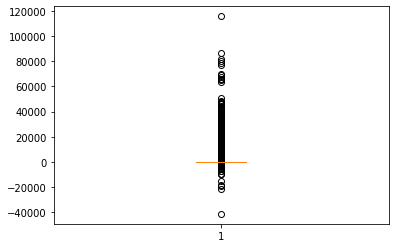

In [56]:
## total(합계) 분포 및 이상치 확인
plt.boxplot(merge_temp['total'])

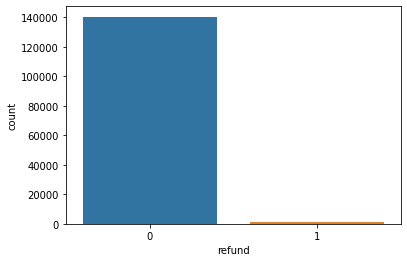

In [57]:
## 환불변수 생성 => 환불사례수는 적어서 모델 돌릴때 제외하기로...

merge_temp['refund'] = 0
merge_temp.loc[merge_temp.total < 0, 'refund'] = 1
merge_temp.head()

sns.countplot(x='refund', data=merge_temp)
#plt.show()

,customer_id,year_month,quantity,price,total,year,month,country_code,refund,quarter
0,12346,2009-12,26.0,31.3500,187.2750,10045.0,60.0,190.0,0,4
1,12346,2010-01,19.0,200.4750,-22.2750,10050.0,5.0,190.0,1,1
2,12346,2010-02,0.0,0.0000,0.0000,0.0,0.0,0.0,0,1
3,12346,2010-03,5.0,44.6325,44.6325,10050.0,15.0,190.0,0,1
4,12346,2010-04,0.0,0.0000,0.0000,0.0,0.0,0.0,0,2


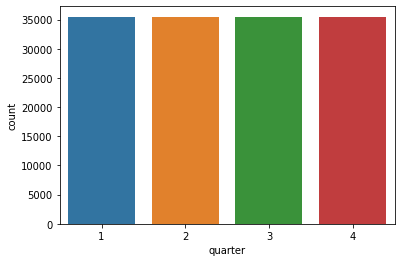

In [58]:
## 분기변수 생성(1~3, 4~6, 7~9, 10~12)

merge_temp['quarter'] = 0
merge_temp.loc[merge_temp.year_month == '2009-12', 'quarter'] = 4

merge_temp.loc[merge_temp.year_month == '2010-01', 'quarter'] = 1
merge_temp.loc[merge_temp.year_month == '2010-02', 'quarter'] = 1
merge_temp.loc[merge_temp.year_month == '2010-03', 'quarter'] = 1

merge_temp.loc[merge_temp.year_month == '2010-04', 'quarter'] = 2
merge_temp.loc[merge_temp.year_month == '2010-05', 'quarter'] = 2
merge_temp.loc[merge_temp.year_month == '2010-06', 'quarter'] = 2

merge_temp.loc[merge_temp.year_month == '2010-07', 'quarter'] = 3
merge_temp.loc[merge_temp.year_month == '2010-08', 'quarter'] = 3
merge_temp.loc[merge_temp.year_month == '2010-09', 'quarter'] = 3

merge_temp.loc[merge_temp.year_month == '2010-10', 'quarter'] = 4
merge_temp.loc[merge_temp.year_month == '2010-11', 'quarter'] = 4
merge_temp.loc[merge_temp.year_month == '2010-12', 'quarter'] = 4

merge_temp.loc[merge_temp.year_month == '2011-01', 'quarter'] = 1
merge_temp.loc[merge_temp.year_month == '2011-02', 'quarter'] = 1
merge_temp.loc[merge_temp.year_month == '2011-03', 'quarter'] = 1

merge_temp.loc[merge_temp.year_month == '2011-04', 'quarter'] = 2
merge_temp.loc[merge_temp.year_month == '2011-05', 'quarter'] = 2
merge_temp.loc[merge_temp.year_month == '2011-06', 'quarter'] = 2

merge_temp.loc[merge_temp.year_month == '2011-07', 'quarter'] = 3
merge_temp.loc[merge_temp.year_month == '2011-08', 'quarter'] = 3
merge_temp.loc[merge_temp.year_month == '2011-09', 'quarter'] = 3

merge_temp.loc[merge_temp.year_month == '2011-10', 'quarter'] = 4
merge_temp.loc[merge_temp.year_month == '2011-11', 'quarter'] = 4


sns.countplot(x='quarter', data=merge_temp)
merge_temp.head()
#merge_temp.groupby('total').mean()

In [59]:
## 불필요 변수 삭제(우선 월변수 이외것은 삭제해보자)
merge_temp = merge_temp.drop(columns = ['country_code', 'year', 'month', 'refund', 'quarter'])

merge_temp.info()
merge_temp['customer_id']==12346


<class 'pandas.core.frame.DataFrame'>
Int64Index: 141936 entries, 0 to 141935
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  141936 non-null  int64  
 1   year_month   141936 non-null  object 
 2   quantity     141936 non-null  float64
 3   price        141936 non-null  float64
 4   total        141936 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.5+ MB


0          True
1          True
2          True
3          True
4          True
          ...  
141931    False
141932    False
141933    False
141934    False
141935    False
Name: customer_id, Length: 141936, dtype: bool

In [60]:
#########################################################################################
## pivot으로 개월을 가로방향으로 데이터 변환함
#########################################################################################

## 2009-12 ~ 2011-11 변수를 가로방향으로 바꾸는 새로운 데이터 생성 => x
df1 = merge_temp.pivot_table(values='total', index='customer_id', columns='year_month')
df1


year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000
12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000
12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575
12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215
18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000


In [61]:
df2 = label.drop(columns = ['year_month', 'label'])
df2.columns = df2.columns.str.replace('total','2011-12')
df2

,customer_id,2011-12
0,12346,0.000
1,12347,370.953
2,12348,0.000
3,12349,0.000
4,12350,0.000
...,...,...
5909,18283,343.200
5910,18284,0.000
5911,18285,0.000
5912,18286,0.000


In [62]:
## df1에 df2(2011-12)를 붙여서 최종데이터 만듬
aaa=df2['2011-12']
df1['2011-12']=aaa.values    # values를 안 적으면 값이 NaN으로 들어가서 붙여야 함
df1


year_month,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,-9.0750,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.000
12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,1009.0245,0.0000,1174.4535,784.3935,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000,370.953
12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,0.0000,0.0000,1473.1200,375.2760,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000,0.000
12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,2314.3230,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575,0.000
12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,0.0000,322.3275,0.0000,352.6875,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215,343.200
18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,720.5220,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.000
18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.000


In [63]:
#########################################################################################
## 모델 분석 (그냥 3개 모델 돌려보자)
#########################################################################################

df1.loc[df1['2011-12'] <= 300, 'target'] = 0
df1.loc[df1['2011-12'] > 300, 'target'] = 1

X = df1.drop(['2011-12', 'target'], axis = 1)
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# DecisionTree Classifier 생성 및 학습
clf = DecisionTreeClassifier(max_depth=5,random_state=0)
clf_model = clf.fit(X_train , y_train)
clf_y_pred = clf.predict(X_test)
print("---"*30)
print("DecisionTree Accuracy on train set: {:.3f}".format(clf.score(X_train, y_train)))
print("DecisionTree Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))

#######################################################################################
# randomforest 분석
rf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=5)
rf_model = rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print("---"*30)
print("RandomForest Train score: ",rf.score(X_train, y_train))
print("RandomForest Test score: ",rf.score(X_test, y_test))
print("---"*30)

#######################################################################################
# AdaBoost classifier
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1,random_state = 7777)
ada_model = ada.fit(X_train, y_train)
ada_y_pred = ada_model.predict(X_test)  
print("Ada boosting Train Accuracy:",ada.score(X_train, y_train))
print("Ada boosting Test Accuracy:",ada.score(X_test, y_test))

------------------------------------------------------------------------------------------
DecisionTree Accuracy on train set: 0.939
DecisionTree Accuracy on test set: 0.926
------------------------------------------------------------------------------------------
RandomForest Train score:  0.9319052987598647
RandomForest Test score:  0.9310344827586207
------------------------------------------------------------------------------------------
Ada boosting Train Accuracy: 0.9368658399098083
Ada boosting Test Accuracy: 0.9303583502366464


In [64]:
#######################################################################################
## 모델 선택 - RandomForest (하이퍼 파라미터 만져보자)
#######################################################################################

# RandomForest의 하이퍼 파라미터 default 상태확인
model = RandomForestClassifier()
model

from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 10}
최고 예측 정확도: 0.9276


In [68]:
## 위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf1 = RandomForestClassifier(n_estimators = 10, 
                                max_depth = 12,
                                min_samples_leaf = 8,
                                min_samples_split = 20,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)

## 오차행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, roc_auc_score
def rf_y_pred(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    AUC = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('*정확도: {0:.4f}, *정밀도: {1:.4f}, *재현율: {2:.4f}, *AUC: {3:.4f}'.format(accuracy , precision ,recall,AUC)
    )

rf_y_pred(y_test, pred)

오차 행렬
[[1365    7]
 [  85   22]]
*정확도: 0.9378, *정밀도: 0.7586, *재현율: 0.2056, *AUC: 0.6003


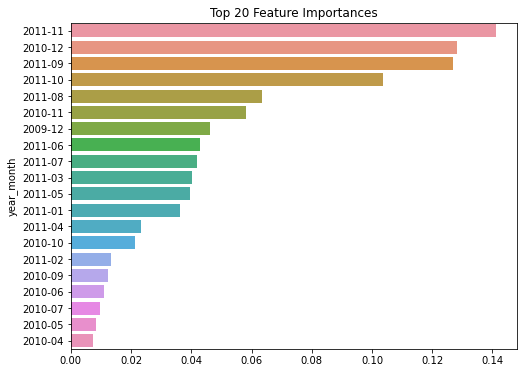

In [69]:
## feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()